## Домашняя работа по теме "CNN свертки"

__Задание__

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets, models
import torchvision
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
print(torch.__version__)

2.0.1+cu117


Загрузка датасета

In [5]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

In [8]:
data_sets = {
    'train': torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='data', download=True, transform=data_transforms['test'])
}

Files already downloaded and verified
Files already downloaded and verified


In [10]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 20

In [11]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}

In [12]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [13]:
def train_model(model):
    train_acces, test_acces = [], []
    train_losses, test_losses = [], []
    total_step = len(dataloaders['train'])
    test_loss_min = np.Inf
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}\n')

        network_learned = False

        for phase in ['train', 'test']:

            running_loss = 0.0
            running_corrects = 0

            if phase == 'train':
                model.train()

                for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)

                    inputs = inputs.float()
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                    if (batch_idx) % 20 == 0:
                        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
                scheduler.step()
            else:
                with torch.no_grad():
                    model.eval()
                    for inputs, labels in dataloaders[phase]:
                        if use_cuda:
                            inputs = Variable(inputs.cuda())
                            labels = Variable(labels.cuda())
                        else:
                            inputs, labels = Variable(inputs), Variable(labels)

                        inputs = inputs.float()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        running_loss += loss.item()
                        running_corrects += torch.sum(preds == labels.data)
                network_learned = running_loss < test_loss_min
                test_loss_min = running_loss if network_learned else test_loss_min


            epoch_loss = running_loss / len(data_sets[phase])
            epoch_acc = running_corrects.double() / len(data_sets[phase])

            if phase == 'train':
                train_acces.append(epoch_acc * 100)
                train_losses.append(epoch_loss)
            else:
                test_acces.append(epoch_acc * 100)
                test_losses.append(epoch_loss)
        print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
        print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

        if network_learned:
            torch.save(model.state_dict(), 'models/weights.h5')
            print('Improvement-Detected, save-model')
            
    if use_cuda:
        train_acces = [_.cpu().item() for _ in train_acces]
        test_acces = [_.cpu().item() for _ in test_acces]
    return train_acces, test_acces, train_losses, test_losses

Собственная сеть

In [14]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        # self.fc2 = torch.nn.Linear(200, 60)
        # self.out = torch.nn.Linear(60, 10)
        self.out = torch.nn.Linear(200, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.dp_four(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        return self.out(x)
    
model_my = Net()
model_my = model_my.cuda() if use_cuda else model_my

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_my.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [18]:
train_acces_my, test_acces_my, train_losses_my, test_losses_my = train_model(model_my)

Epoch 0

Epoch [0/19], Step [0/782], Loss: 3.1767
Epoch [0/19], Step [20/782], Loss: 3.2830
Epoch [0/19], Step [40/782], Loss: 3.0700
Epoch [0/19], Step [60/782], Loss: 3.2495
Epoch [0/19], Step [80/782], Loss: 3.4263
Epoch [0/19], Step [100/782], Loss: 3.4335
Epoch [0/19], Step [120/782], Loss: 3.3946
Epoch [0/19], Step [140/782], Loss: 3.4966
Epoch [0/19], Step [160/782], Loss: 3.1938
Epoch [0/19], Step [180/782], Loss: 3.2298
Epoch [0/19], Step [200/782], Loss: 3.3202
Epoch [0/19], Step [220/782], Loss: 3.1025
Epoch [0/19], Step [240/782], Loss: 3.2652
Epoch [0/19], Step [260/782], Loss: 3.2072
Epoch [0/19], Step [280/782], Loss: 3.0930
Epoch [0/19], Step [300/782], Loss: 3.0875
Epoch [0/19], Step [320/782], Loss: 2.9742
Epoch [0/19], Step [340/782], Loss: 2.7246
Epoch [0/19], Step [360/782], Loss: 3.2730
Epoch [0/19], Step [380/782], Loss: 3.0818
Epoch [0/19], Step [400/782], Loss: 2.9757
Epoch [0/19], Step [420/782], Loss: 3.1868
Epoch [0/19], Step [440/782], Loss: 3.0070
Epoch [0

Отрисуем метрику Accuracy для трейна и теста:

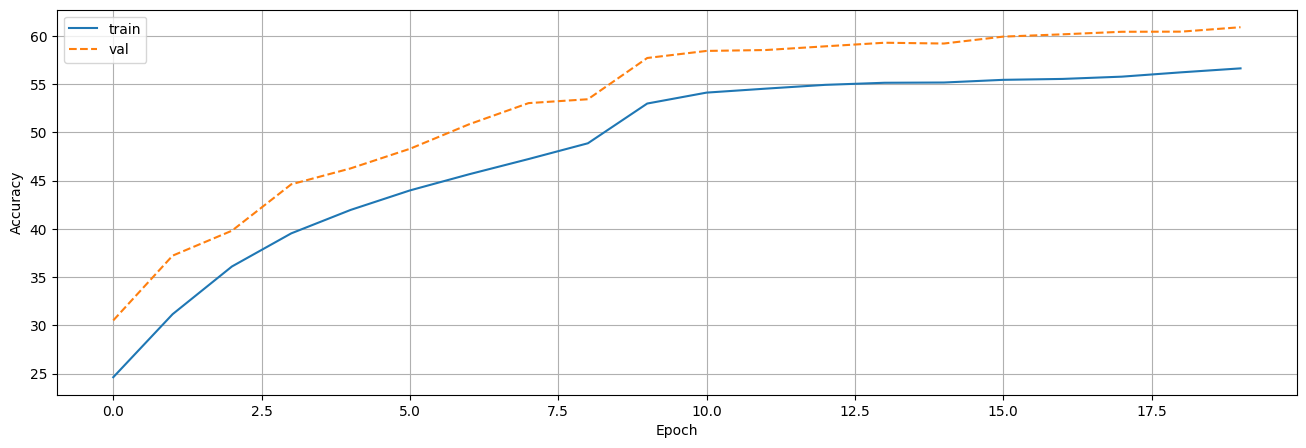

In [19]:
plt.figure(figsize = (16,5))
plt.plot(train_acces_my,'-',label = f'train')
plt.plot(test_acces_my,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

# CNN: дообучение ResNet-50

In [22]:
model = models.resnet50(pretrained=True)

model = model.cuda() if use_cuda else model
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Полина\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Полина/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:24<00:00, 4.18MB/s]


In [23]:
train_acces, test_acces, train_losses, test_losses = train_model(model)

Epoch 0

Epoch [0/19], Step [0/782], Loss: 4.5799
Epoch [0/19], Step [20/782], Loss: 4.6053
Epoch [0/19], Step [40/782], Loss: 4.5784
Epoch [0/19], Step [60/782], Loss: 4.6028
Epoch [0/19], Step [80/782], Loss: 4.5667
Epoch [0/19], Step [100/782], Loss: 4.5757
Epoch [0/19], Step [120/782], Loss: 4.5705
Epoch [0/19], Step [140/782], Loss: 4.5156
Epoch [0/19], Step [160/782], Loss: 4.5221
Epoch [0/19], Step [180/782], Loss: 4.4223
Epoch [0/19], Step [200/782], Loss: 4.4813
Epoch [0/19], Step [220/782], Loss: 4.1685
Epoch [0/19], Step [240/782], Loss: 4.2345
Epoch [0/19], Step [260/782], Loss: 4.0665
Epoch [0/19], Step [280/782], Loss: 4.1799
Epoch [0/19], Step [300/782], Loss: 3.7873
Epoch [0/19], Step [320/782], Loss: 3.7965
Epoch [0/19], Step [340/782], Loss: 3.5204
Epoch [0/19], Step [360/782], Loss: 3.3870
Epoch [0/19], Step [380/782], Loss: 3.7202
Epoch [0/19], Step [400/782], Loss: 3.4699
Epoch [0/19], Step [420/782], Loss: 3.4072
Epoch [0/19], Step [440/782], Loss: 3.2331
Epoch [0

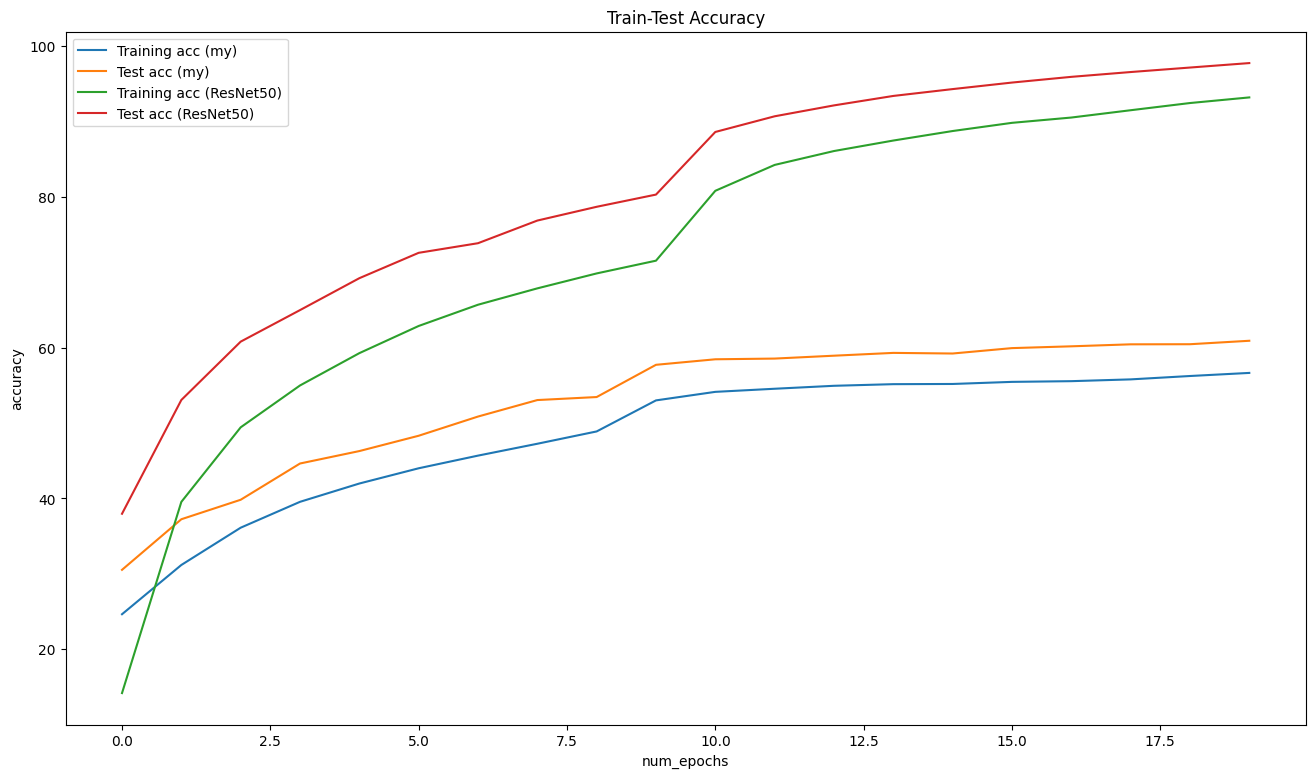

In [24]:
plt.figure(figsize=(16, 9))
plt.title("Train-Test Accuracy")
plt.plot(train_acces_my, label='Training acc (my)')
plt.plot(test_acces_my, label='Test acc (my)')
plt.plot(train_acces, label='Training acc (ResNet50)')
plt.plot(test_acces, label='Test acc (ResNet50)')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend();

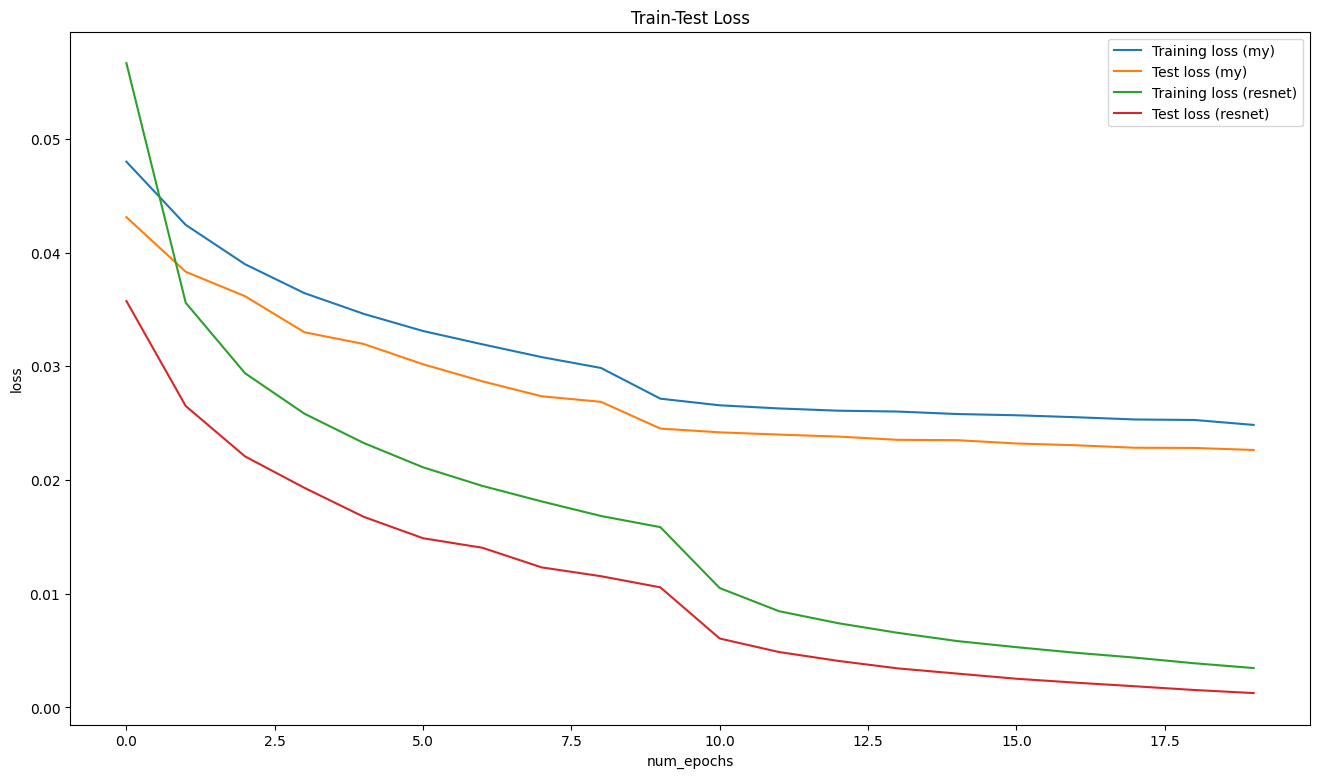

In [25]:
plt.figure(figsize=(16, 9))
plt.title("Train-Test Loss")
plt.plot(train_losses_my, label='Training loss (my)')
plt.plot(test_losses_my, label='Test loss (my)')
plt.plot(train_losses, label='Training loss (resnet)')
plt.plot(test_losses, label='Test loss (resnet)')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend();